**This is the ML Depression Prediction Using the 2023 BRFSS dataset**

Load packages needed for the analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from google.colab import files

Load the dataset

In [ ]:
uploaded = files.upload()

Saving Selected_BRFSS_Cleaned_Nomiss_Final.dta to Selected_BRFSS_Cleaned_Nomiss_Final (2).dta


**Importing the dataset and take a look at it**

In [ ]:
# import Stata dataset
dhs18 = pd.read_stata('Selected_BRFSS_Cleaned_Nomiss_Final.dta', convert_categoricals=False)

In [ ]:
# Take a look at the dataset
dhs18.shape

(5596, 26)

In [ ]:
# Drop one of the variables in the analysis
dhs18 = dhs18.drop(columns=['poor_ment_days'])


In [ ]:
dhs18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5596 entries, 0 to 5595
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   self_health_good      5596 non-null   int64  
 1   poor_phys_days        5596 non-null   int64  
 2   has_health_insurance  5596 non-null   int64  
 3   physically_active     5596 non-null   int64  
 4   race_ethnicity_5cat   5596 non-null   int64  
 5   sex                   5596 non-null   int64  
 6   age_group_6cat        5596 non-null   int64  
 7   bmi_category          5596 non-null   int64  
 8   num_children          5596 non-null   int64  
 9   education_level       5596 non-null   int64  
 10  smoking_status        5596 non-null   int64  
 11  drank_past_30d        5596 non-null   int64  
 12  depression_dx         5596 non-null   int8   
 13  home_ownership        5596 non-null   int64  
 14  veteran_status        5596 non-null   int64  
 15  pregnant_status      

In [ ]:
dhs18.columns

Index(['self_health_good', 'poor_phys_days', 'has_health_insurance',
       'physically_active', 'race_ethnicity_5cat', 'sex', 'age_group_6cat',
       'bmi_category', 'num_children', 'education_level', 'smoking_status',
       'drank_past_30d', 'depression_dx', 'home_ownership', 'veteran_status',
       'pregnant_status', 'urban_rural', 'memory_decline', 'is_caregiver',
       'Comorbid_Cat', 'Cancer_diagnosis', 'ACES_Cat', 'married_binary',
       'employed_binary', 'disability_Cat'],
      dtype='object')

In [ ]:
# Defining the X variables
x = dhs18 [['self_health_good', 'poor_phys_days',
       'has_health_insurance', 'physically_active', 'race_ethnicity_5cat',
       'sex', 'age_group_6cat', 'bmi_category', 'num_children',
       'education_level', 'smoking_status', 'drank_past_30d',
       'home_ownership', 'veteran_status', 'pregnant_status', 'urban_rural',
       'memory_decline', 'is_caregiver', 'Comorbid_Cat', 'Cancer_diagnosis',
       'ACES_Cat', 'married_binary', 'employed_binary', 'disability_Cat']]

In [ ]:
# Take a look at the X variables
x.shape

(5596, 24)

In [ ]:
# Checking for missing values
x.isnull().sum()

,0
self_health_good,0
poor_phys_days,0
has_health_insurance,0
physically_active,0
race_ethnicity_5cat,0
sex,0
age_group_6cat,0
bmi_category,0
num_children,0
education_level,0


In [ ]:
# Defining the Y variable in the analysis
y = dhs18.depression_dx

In [ ]:
# Take a look at the Y variable
y.shape

(5596,)

In [ ]:
y.value_counts()

,count
depression_dx,
0,4072
1,1524


In [ ]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5596 entries, 0 to 5595
Series name: depression_dx
Non-Null Count  Dtype
--------------  -----
5596 non-null   int8 
dtypes: int8(1)
memory usage: 5.6 KB


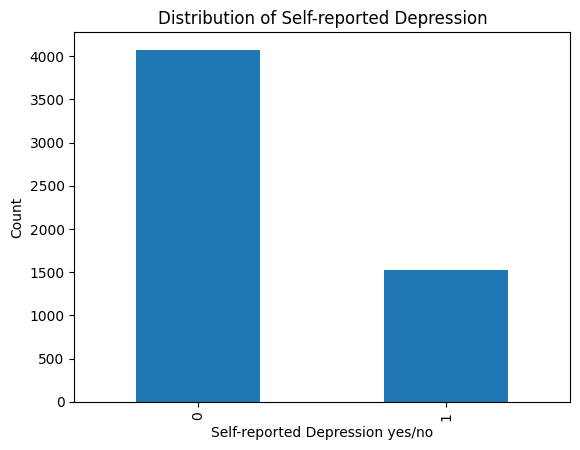

In [ ]:
# prompt: plot a plot for the y.value_counts
y.value_counts().plot(kind='bar')
plt.title('Distribution of Self-reported Depression')
plt.xlabel('Self-reported Depression yes/no')
plt.ylabel('Count')
plt.show()

**Checking for Multicollinearity between the variables**

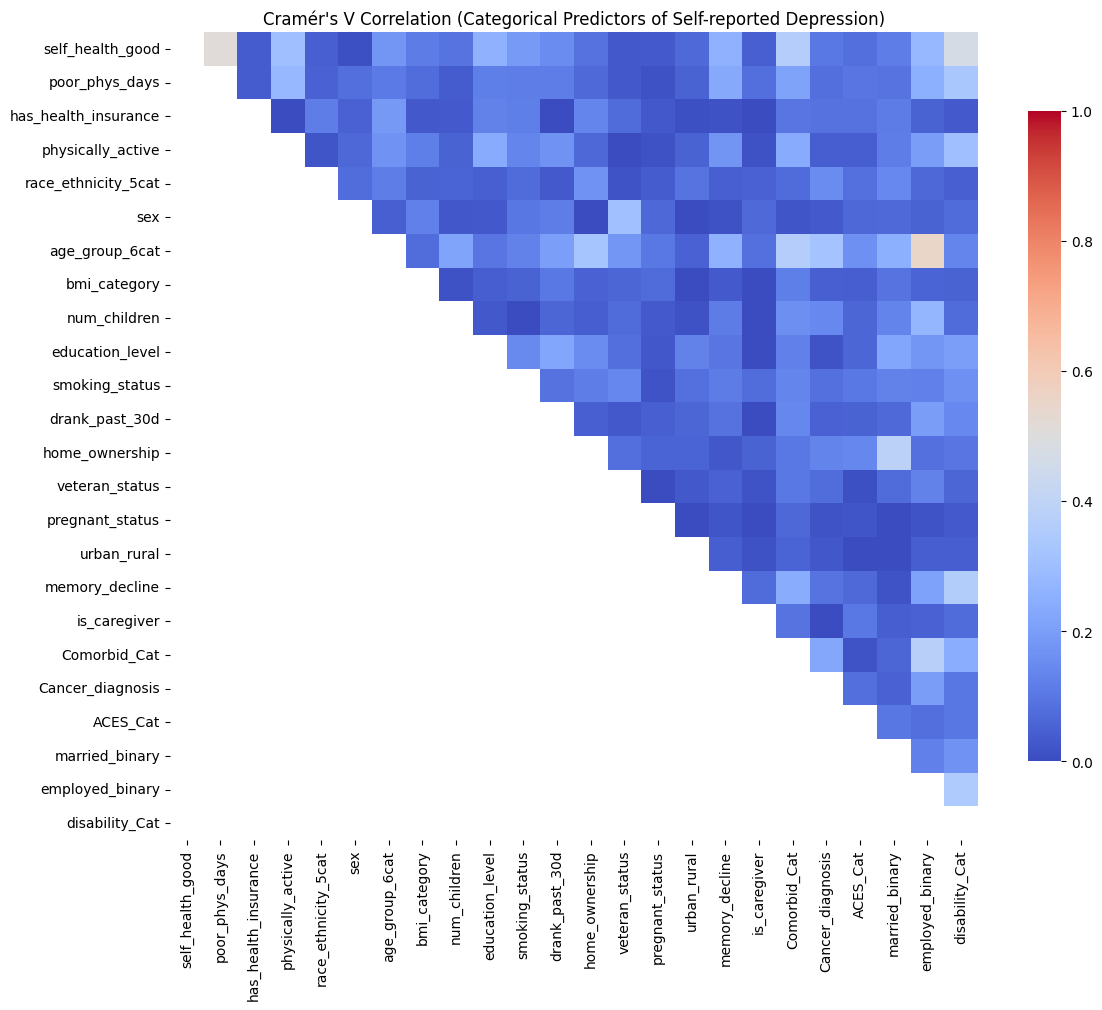


Pairs with Cramér's V ≥ 0.7 (possible redundancy):
  None at or above threshold.


In [ ]:
# ==== Multicollinearity among categorical predictors via Cramér's V ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 1) Cramér's V (bias-corrected) for two categorical Series
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    tbl = pd.crosstab(x, y, dropna=False)
    # Need at least 2x2 table with variation
    if tbl.shape[0] < 2 or tbl.shape[1] < 2:
        return 0.0
    chi2 = chi2_contingency(tbl, correction=False)[0]
    n = tbl.values.sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = tbl.shape
    # Bias correction (Bergsma 2013)
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

# 2) Ensure everything in X is treated as categorical (string safe-cast)
X_cat = x.copy().astype("category").apply(lambda s: s.astype(str)).fillna("Missing")

cols = X_cat.columns.tolist()
n = len(cols)
cramers = pd.DataFrame(np.eye(n), index=cols, columns=cols)

for i in range(n):
    for j in range(i + 1, n):
        v = cramers_v(X_cat.iloc[:, i], X_cat.iloc[:, j])
        cramers.iat[i, j] = v
        cramers.iat[j, i] = v

# 3) Heatmap (upper triangle)
mask = np.tril(np.ones_like(cramers, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(cramers, mask=mask, cmap="coolwarm", vmin=0, vmax=1,
            square=True, cbar_kws={"shrink": 0.8})
plt.title("Cramér's V Correlation (Categorical Predictors of Self-reported Depression)")
plt.tight_layout()
plt.show()

# 4) Print the strongest pairs (adjust threshold as needed)
THRESH = 0.7  # <-- set your concern threshold here
pairs = []
for i in range(n):
    for j in range(i + 1, n):
        pairs.append((cols[i], cols[j], cramers.iat[i, j]))
strong_pairs = sorted([p for p in pairs if p[2] >= THRESH], key=lambda x: x[2], reverse=True)

print(f"\nPairs with Cramér's V ≥ {THRESH} (possible redundancy):")
if strong_pairs:
    for a, b, v in strong_pairs:
        print(f"  {a}  ~  {b}:  {v:.2f}")
else:
    print("  None at or above threshold.")

# Optional: save matrix for appendix/supplement
# cramers.to_csv("cramers_v_matrix.csv", index=True)


**Apply the Synthetic Minority Over-sampling Technique (SMOTE)**

Class balance (full):
depression_dx
0    4072
1    1524
Name: count, dtype: int64 

Train before SMOTE:
depression_dx
0    3257
1    1219
Name: count, dtype: int64

Test (never resampled):
depression_dx
0    815
1    305
Name: count, dtype: int64

Train after SMOTE:
depression_dx
1    3257
0    3257
Name: count, dtype: int64


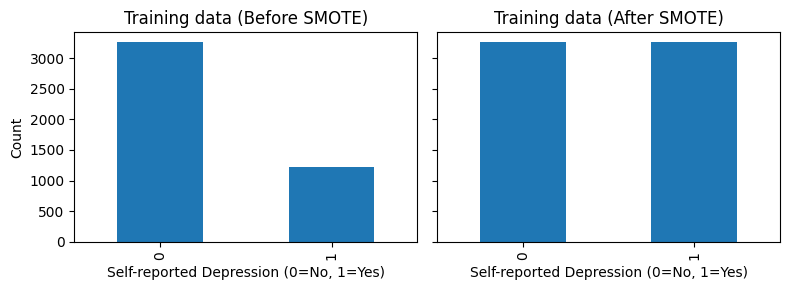

In [ ]:
# ==== SMOTE on TRAIN ONLY for all-categorical predictors ====
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1) Train/test split (test stays untouched by SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42, stratify=y
)

print("Class balance (full):")
print(y.value_counts(), "\n")
print("Train before SMOTE:")
print(y_train.value_counts())
print("\nTest (never resampled):")
print(y_test.value_counts())

# 2) Preprocess: impute most-frequent + one-hot for ALL columns (all are categorical)
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             # FIX: use sparse_output=False (new sklearn >=1.2)
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         x.columns.tolist()
        )
    ],
    remainder="drop"
)

# 3) Build pipeline: transform -> SMOTE   (no classifier yet)
smote_pipe = ImbPipeline(steps=[
    ("prep", preprocess_cat),
    ("smote", SMOTE(random_state=42))
])

# 4) Fit-resample on TRAINING ONLY
X_resampled, y_resampled = smote_pipe.fit_resample(X_train, y_train)

print("\nTrain after SMOTE:")
print(y_resampled.value_counts())

# 5) Quick bar plots for train counts before/after
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
y_train.value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Training data (Before SMOTE)")
y_resampled.value_counts().sort_index().plot(kind="bar", ax=axes[1], title="Training data (After SMOTE)")
for ax in axes:
    ax.set_xlabel("Self-reported Depression (0=No, 1=Yes)")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

**Cross-validation For the Analysis**

In [ ]:
# ==== Cross-validation setup (before model building) ====
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# Preprocess (all predictors are categorical)
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         x.columns.tolist()
        )
    ],
    remainder="drop"
)

# Model
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced")

# Pipeline: preprocess -> SMOTE (train folds only) -> model
rf_pipe = ImbPipeline(steps=[
    ("prep", preprocess_cat),
    ("smote", SMOTE(random_state=42)),
    ("clf", rf)
])

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_pipe, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"CV accuracies: {np.round(cv_scores, 4)}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"SD: {cv_scores.std():.4f}")


CV accuracies: [0.7511 0.7676 0.7933 0.7709 0.7687]
Mean accuracy: 0.7703
SD: 0.0135


**Model Building and Evaluation**

In [ ]:
# ==== Build & evaluate models (LR, NB, SVM, KNN, DT, RF, GB, XGB) ====

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB  # <-- added (good for one-hot / binary features)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

import numpy as np
import pandas as pd

# Preprocess: all predictors are categorical
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # sklearn ≥1.2
         ]),
         x.columns.tolist()
        )
    ],
    remainder="drop"
)

def make_pipe(est):
    # SMOTE happens inside fit on training folds or training set (no leakage to test)
    return ImbPipeline(steps=[
        ("prep", preprocess_cat),
        ("smote", SMOTE(random_state=42)),
        ("clf", est)
    ])

models = {
    "LR":  LogisticRegression(max_iter=2000, solver="lbfgs"),
    "NB":  BernoulliNB(alpha=1.0),  # <-- added Naive Bayes (robust baseline for one-hot)
    "SVM": SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "DT":  DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
    "RF":  RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42, class_weight=None),
    "GB":  GradientBoostingClassifier(random_state=42),
    "XGB": XGBClassifier(
        n_estimators=600, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, eval_metric="auc",
        tree_method="hist", random_state=42
    )
}

rows = []
fitted = {}

for name, est in models.items():
    pipe = make_pipe(est)
    pipe.fit(X_train, y_train)  # train only (SMOTE applied here)
    fitted[name] = pipe

    # Some classifiers may not expose predict_proba; handle that safely
    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe, "decision_function"):
        # Convert decision scores to [0,1] via logistic transform (for AUROC/PR-AUC)
        scores = pipe.decision_function(X_test)
        proba = 1 / (1 + np.exp(-scores))
    else:
        proba = None

    pred = pipe.predict(X_test)

    row = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0),
        "BalancedAcc": balanced_accuracy_score(y_test, pred)
    }

    if proba is not None:
        row.update({
            "AUROC": roc_auc_score(y_test, proba),
            "PR-AUC": average_precision_score(y_test, proba)
        })
    else:
        row.update({"AUROC": np.nan, "PR-AUC": np.nan})

    rows.append(row)

results_df = pd.DataFrame(rows).sort_values("AUROC", ascending=False)
print("\nHold-out Test Performance (original, unresampled test set):")
display(results_df.round(3))

# Optional: detailed report/confusion matrix for the top model
best_name = results_df.iloc[0]["Model"]
best = fitted[best_name]
best_pred = best.predict(X_test)

print(f"\n=== Detailed report for best model: {best_name} ===")
print(classification_report(y_test, best_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, best_pred))



Hold-out Test Performance (original, unresampled test set):


,Model,Accuracy,Precision,Recall,F1,BalancedAcc,AUROC,PR-AUC
6,GB,0.771,0.598,0.492,0.540,0.684,0.788,0.607
0,LR,0.713,0.482,0.708,0.574,0.712,0.785,0.620
7,XGB,0.774,0.617,0.449,0.520,0.672,0.781,0.591
2,SVM,0.759,0.560,0.534,0.547,0.689,0.775,0.588
5,RF,0.776,0.621,0.456,0.526,0.676,0.773,0.585
1,NB,0.733,0.508,0.610,0.554,0.694,0.758,0.572
3,KNN,0.621,0.399,0.770,0.526,0.668,0.745,0.522
4,DT,0.720,0.482,0.397,0.435,0.619,0.650,0.391



=== Detailed report for best model: GB ===
              precision    recall  f1-score   support

           0      0.822     0.876     0.848       815
           1      0.598     0.492     0.540       305

    accuracy                          0.771      1120
   macro avg      0.710     0.684     0.694      1120
weighted avg      0.761     0.771     0.764      1120

Confusion matrix:
 [[714 101]
 [155 150]]


**For Gradient Boosting Model**

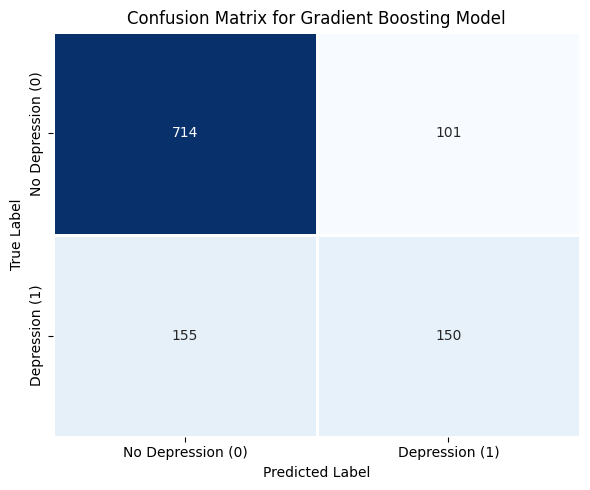


Specificity (True Negative Rate): 0.876
Sensitivity (True Positive Rate): 0.492


In [ ]:
# ==== Confusion Matrix for the Best Model (Gradient Boosting (GB) Model) ====

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class labels using the best model (LR)
y_pred_best = (best.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

labels = ["No Depression (0)", "Depression (1)"]

# Heatmap visualization
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels,
    cbar=False, linewidths=1
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Gradient Boosting Model")
plt.tight_layout()
plt.show()

# Optional: Class-wise performance rates
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nSpecificity (True Negative Rate): {specificity:.3f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")

**For Logistic Regression Model**

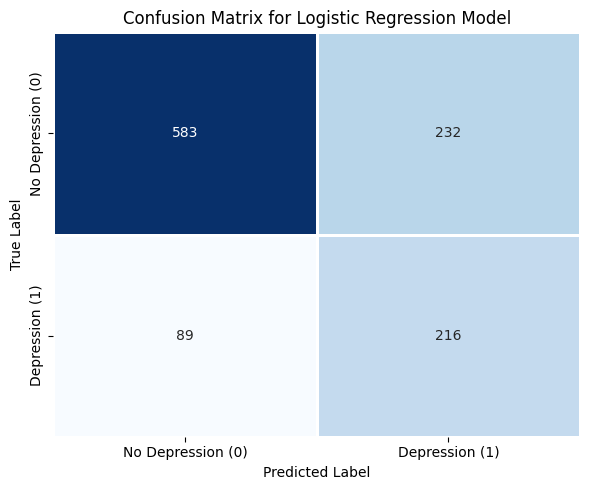

Specificity (True Negative Rate): 0.715
Sensitivity (True Positive Rate): 0.708


In [ ]:
# ==== Confusion Matrix for the Logistic Regression (LR) Model ====

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Retrieve Logistic Regression model from fitted dictionary
lr_model = fitted["LR"]   # trained LR pipeline

# Predict class labels for the test set (0.5 threshold)
y_pred_lr = (lr_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

labels = ["No Depression (0)", "Depression (1)"]

# Heatmap visualization
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=1
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Logistic Regression Model")
plt.tight_layout()
plt.show()

# Class-wise performance metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan

print(f"Specificity (True Negative Rate): {specificity:.3f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")

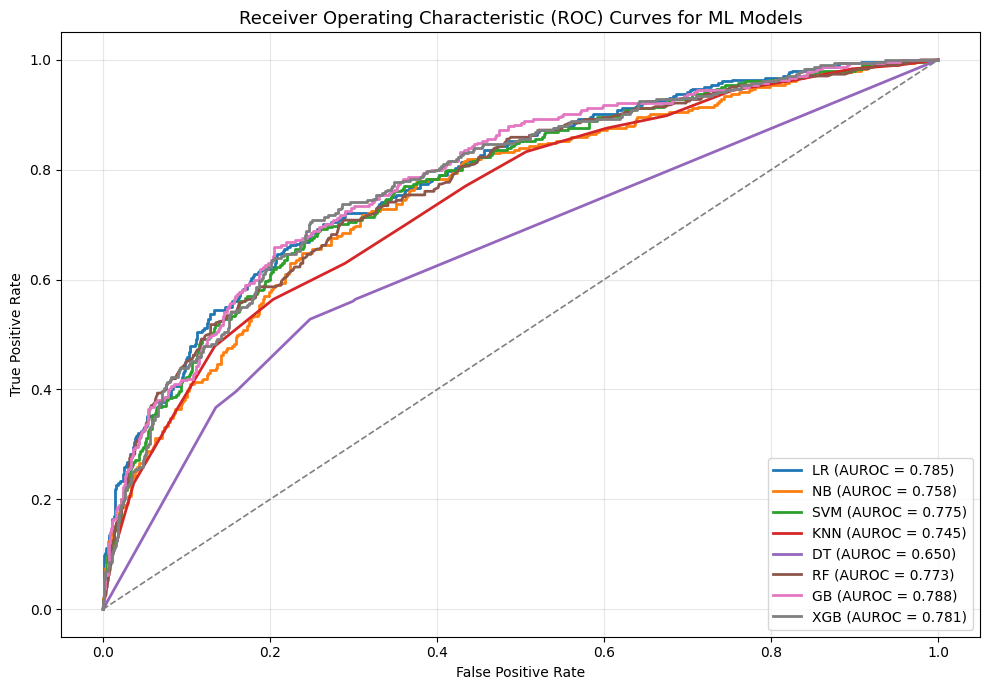

In [ ]:
# ==== ROC Curves for All Models ====
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))

# Use the fitted dictionary of trained pipelines from your previous step
for name, model in fitted.items():
    # Predict probabilities for positive class
    y_score = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and area under curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUROC = {roc_auc:.3f})')

# Add chance line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1.2)

# Styling
plt.title('Receiver Operating Characteristic (ROC) Curves for ML Models', fontsize=13)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


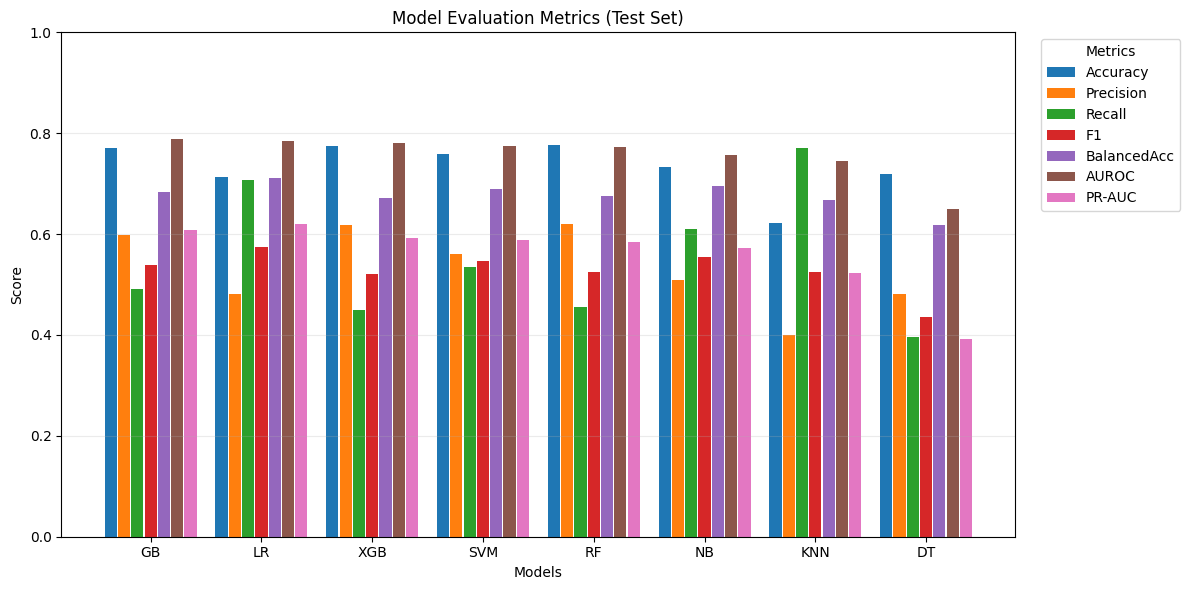

In [ ]:
# ==== Grouped bar chart of model metrics (incl. BalancedAcc, PR-AUC) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you already have results_df from earlier, use it; otherwise build it from your lists.
# results_df should have columns: Model, Accuracy, Precision, Recall, F1, BalancedAcc, AUROC, PR-AUC
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "BalancedAcc", "AUROC", "PR-AUC"]

plot_df = results_df.set_index("Model")[metrics_to_plot].copy()
model_names = plot_df.index.tolist()
M = len(model_names)
K = len(metrics_to_plot)

# Bar positions
x = np.arange(M)
bar_w = 0.11
offsets = (np.arange(K) - (K-1)/2) * (bar_w + 0.01)

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + offsets[i], plot_df[metric].values, width=bar_w, label=metric)

# Labels & styling
plt.xticks(x, model_names, rotation=0, fontsize=10)
plt.ylim(0, 1.0)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Evaluation Metrics (Test Set)")
plt.legend(title="Metrics", loc="upper left", bbox_to_anchor=(1.02, 1))
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Initialize list for results
conf_list = []

# Loop through all trained models
for name, model in fitted.items():
    # Predict on test data
    y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    conf_list.append({
        "Model": name,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

# Convert to DataFrame
conf_df = pd.DataFrame(conf_list)

# Order the models in the same order as before (optional)
model_order = ["LR", "SVM", "KNN", "DT", "NB", "RF", "GB", "XGB"]
conf_df = conf_df.set_index("Model").loc[model_order].reset_index()

# Display the table
print("\nConfusion Matrix Counts (Test Set)")
display(conf_df)



Confusion Matrix Counts (Test Set)


,Model,TP,FP,FN,TN
0,LR,216,232,89,583
1,SVM,170,133,135,682
2,KNN,235,354,70,461
3,DT,161,202,144,613
4,NB,186,180,119,635
5,RF,139,87,166,728
6,GB,150,101,155,714
7,XGB,137,85,168,730


**Recursive Feature Elimination (RFE)** is a feature selection technique that works by iteratively removing the least important features from a model until the desired number of features is reached.

Transformed feature count: 70
Selected 66 features (of 70).

Top selected features (first 20):


,feature,selected,rank
0,self_health_good_0.0,True,1
1,self_health_good_1.0,True,1
2,poor_phys_days_0.0,True,1
3,poor_phys_days_1.0,True,1
4,poor_phys_days_2.0,True,1
5,has_health_insurance_0.0,True,1
7,physically_active_0.0,True,1
8,physically_active_1.0,True,1
9,race_ethnicity_5cat_0.0,True,1
10,race_ethnicity_5cat_1.0,True,1



=== Test Performance with RFECV-selected features ===
Accuracy:       0.777
Precision:      0.609
Recall:         0.505
F1:             0.552
Balanced Acc:   0.692
AUROC:          0.786
PR-AUC:         0.602

Classification report:
               precision    recall  f1-score   support

           0      0.826     0.879     0.851       815
           1      0.609     0.505     0.552       305

    accuracy                          0.777      1120
   macro avg      0.717     0.692     0.702      1120
weighted avg      0.767     0.777     0.770      1120

Confusion matrix:
 [[716  99]
 [151 154]]

Top contributing features (model importances):


,Feature,Importance
63,disability_Cat_0.0,0.143602
2,poor_phys_days_0.0,0.140894
58,ACES_Cat_2.0,0.080664
56,ACES_Cat_0.0,0.067681
19,age_group_6cat_5.0,0.059564
51,Comorbid_Cat_0.0,0.049623
14,sex_1.0,0.048864
13,sex_0.0,0.041235
32,education_level_3.0,0.026215
57,ACES_Cat_1.0,0.019672


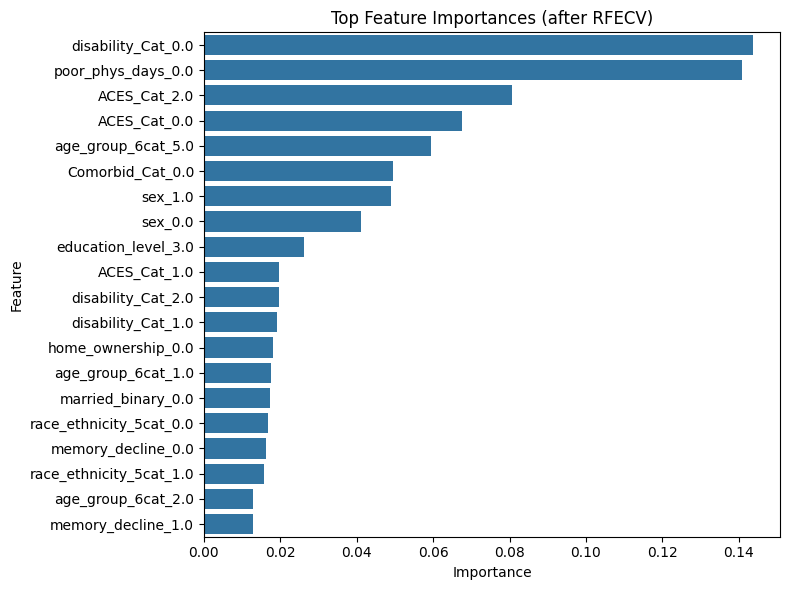

In [ ]:
# ==== RFECV with categorical preprocessing (train-only) ====

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier  # or RandomForestClassifier
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure X_train / X_test are DataFrames (so .columns exists)
if not hasattr(X_train, "columns"):
    X_train = pd.DataFrame(X_train)
if not hasattr(X_test, "columns"):
    X_test = pd.DataFrame(X_test)

feature_cols = X_train.columns.tolist()

# ---- 1) Preprocess on TRAIN ONLY (all categorical)
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         feature_cols
        )
    ],
    remainder="drop"
)

prep = preprocess_cat.fit(X_train)   # fit on train only
Xtr = prep.transform(X_train)
Xte = prep.transform(X_test)

# Get feature names after one-hot
oh = prep.named_transformers_["cat"].named_steps["onehot"]
feat_names = list(oh.get_feature_names_out(feature_cols))

print(f"Transformed feature count: {len(feat_names)}")

# ---- 2) RFECV using your best model (choose GB or RF)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_est = GradientBoostingClassifier(random_state=42)
# Or:
# from sklearn.ensemble import RandomForestClassifier
# base_est = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)

rfecv = RFECV(
    estimator=base_est,
    step=1,
    cv=skf,
    scoring="roc_auc",
    min_features_to_select=10,
    n_jobs=-1
)

rfecv.fit(Xtr, y_train)  # TRAIN ONLY

print(f"Selected {rfecv.n_features_} features (of {Xtr.shape[1]}).")

# ---- 3) Selected feature names + rankings
support_mask = rfecv.support_
ranking = rfecv.ranking_

selected_features = [f for f, keep in zip(feat_names, support_mask) if keep]
rfe_table = (pd.DataFrame({"feature": feat_names, "selected": support_mask, "rank": ranking})
             .sort_values(["selected", "rank"], ascending=[False, True]))

print("\nTop selected features (first 20):")
display(rfe_table[rfe_table["selected"]].head(20))

# ---- 4) Transform TRAIN/TEST to selected columns only
Xtr_sel = Xtr[:, support_mask]
Xte_sel = Xte[:, support_mask]

# Optional: SMOTE on TRAIN ONLY after selection
Xtr_bal, ytr_bal = SMOTE(random_state=42).fit_resample(Xtr_sel, y_train)

# ---- 5) Fit the same base model on selected features and evaluate
final_clf = base_est.__class__(**base_est.get_params())  # fresh copy
final_clf.fit(Xtr_bal, ytr_bal)

proba = final_clf.predict_proba(Xte_sel)[:, 1]
pred  = (proba >= 0.5).astype(int)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             balanced_accuracy_score, roc_auc_score, average_precision_score,
                             classification_report, confusion_matrix)

print("\n=== Test Performance with RFECV-selected features ===")
print(f"Accuracy:       {accuracy_score(y_test, pred):.3f}")
print(f"Precision:      {precision_score(y_test, pred, zero_division=0):.3f}")
print(f"Recall:         {recall_score(y_test, pred, zero_division=0):.3f}")
print(f"F1:             {f1_score(y_test, pred, zero_division=0):.3f}")
print(f"Balanced Acc:   {balanced_accuracy_score(y_test, pred):.3f}")
print(f"AUROC:          {roc_auc_score(y_test, proba):.3f}")
print(f"PR-AUC:         {average_precision_score(y_test, proba):.3f}")
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

# ---- 6) (Optional) Feature importance on selected features
if hasattr(final_clf, "feature_importances_"):
    imp = (pd.DataFrame({"Feature": selected_features,
                         "Importance": final_clf.feature_importances_})
           .sort_values("Importance", ascending=False))

    print("\nTop contributing features (model importances):")
    display(imp.head(20))

    plt.figure(figsize=(8, 6))
    sns.barplot(x="Importance", y="Feature", data=imp.head(20))
    plt.title("Top Feature Importances (after RFECV)")
    plt.tight_layout()
    plt.show()

**SHAP (SHapley Additive exPlanations)** is a game-theoretic approach used to explain the output of any machine learning model. SHAP values quantify the contribution of each feature to a specific prediction made by a machine learning model. Imagine a cooperative game where each feature is a "player" contributing to the final prediction. SHAP values determine the fair contribution of each player to the game's outcome, considering all possible combinations of features.

**Gradient Boosting Model & SHAP**

Top variables by aggregated mean |SHAP| values (GB Depression model):


,base,mean_abs_shap
5,disability_Cat,0.531488
3,age_group_6cat,0.489779
0,ACES_Cat,0.432453
20,sex,0.387763
16,poor_phys_days,0.307800
2,Comorbid_Cat,0.290006
12,married_binary,0.148726
13,memory_decline,0.142709
15,physically_active,0.136385
18,race_ethnicity_5cat,0.125613


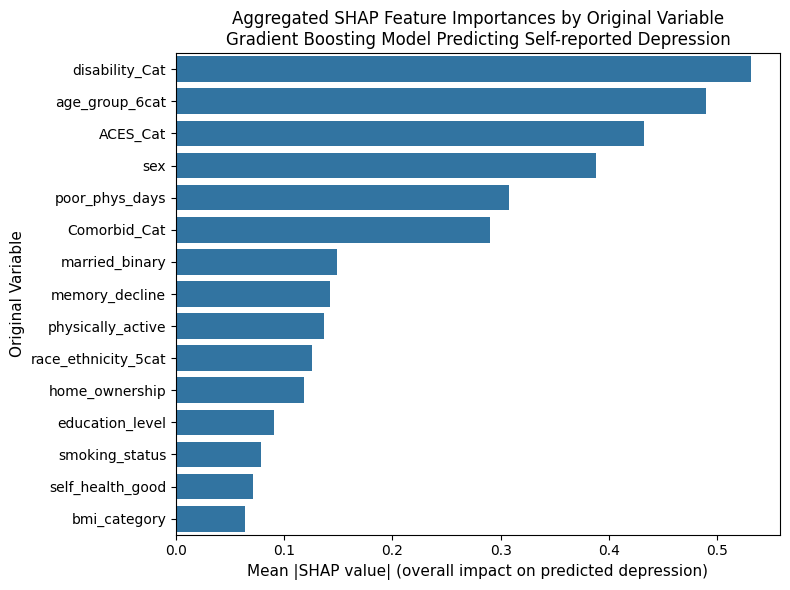


Number of original variables (groups): 24


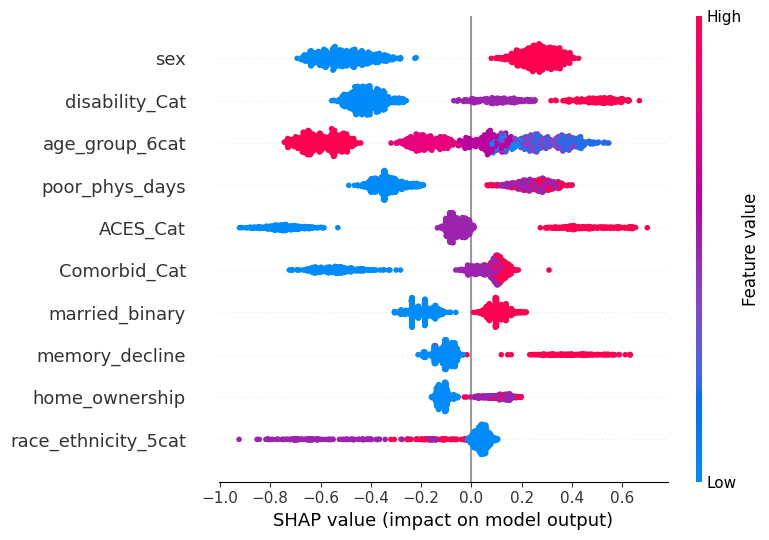

In [ ]:
# ==== Aggregated SHAP Feature Importance + Grouped Beeswarm for GB (Depression model) ====
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# -------------------------------------------------------------------
# 0) Pull GB pipeline and build SHAP explainer
# -------------------------------------------------------------------
# Assumes:
#   fitted["GB"] -> trained GB pipeline (prep + smote + clf)
#   X_test       -> original test DataFrame (same columns used in training)
#   y_test       -> binary outcome (0/1)

gb_model = fitted["GB"]
prep = gb_model.named_steps["prep"]   # ColumnTransformer
clf  = gb_model.named_steps["clf"]    # GradientBoostingClassifier

# Transform X_test (no SMOTE at inference)
X_test_tx = prep.transform(X_test)

# Get original feature names used by the transformer (works even if you didn't define `predictors`)
feature_cols = prep.feature_names_in_.tolist() if hasattr(prep, "feature_names_in_") else X_test.columns.tolist()

# Get post-encoding feature names
oh = prep.named_transformers_["cat"].named_steps["onehot"]
feat_names = list(oh.get_feature_names_out(input_features=feature_cols))

# TreeExplainer for GB
explainer = shap.TreeExplainer(clf)
shap_vals = explainer.shap_values(X_test_tx)

# Handle binary output shapes across SHAP versions
# - Sometimes returns (n_samples, n_features)
# - Sometimes returns list [class0, class1]
# - Sometimes returns (n_samples, n_features, n_classes)
if isinstance(shap_vals, list):
    shap_vals_pos = shap_vals[1]
elif getattr(shap_vals, "ndim", 0) == 3:
    shap_vals_pos = shap_vals[:, :, 1]
else:
    shap_vals_pos = shap_vals

# -------------------------------------------------------------------
# 1) Aggregate SHAP values by original variable (post-OHE groups)
# -------------------------------------------------------------------
def base_var(name: str) -> str:
    """
    Convert one-hot feature names like:
      'race_ethnicity_5cat_3' or 'sex_1'
    back to the original variable name.

    This is robust to underscores in the original variable name.
    """
    # SHAP/Sklearn OHE uses pattern: "<original>_<category>"
    # We strip the last "_<category>" chunk.
    if "_" in name:
        return name.rsplit("_", 1)[0]
    return name

mean_abs = np.mean(np.abs(shap_vals_pos), axis=0)

agg = (
    pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
      .assign(base=lambda d: d["feature"].map(base_var))
      .groupby("base", as_index=False)["mean_abs_shap"].sum()
      .sort_values("mean_abs_shap", ascending=False)
)

print("Top variables by aggregated mean |SHAP| values (GB Depression model):")
display(agg.head(15))

# -------------------------------------------------------------------
# 2) Bar plot of aggregated SHAP importances (original variables)
# -------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=agg.head(15),
    x="mean_abs_shap",
    y="base"
)
plt.title(
    "Aggregated SHAP Feature Importances by Original Variable\nGradient Boosting Model Predicting Self-reported Depression",
)
plt.xlabel("Mean |SHAP value| (overall impact on predicted depression)", fontsize=11)
plt.ylabel("Original Variable", fontsize=11)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3) Grouped SHAP beeswarm at original-variable level
# -------------------------------------------------------------------
# Build mapping from encoded features -> base variable
groups = {}
for idx, fname in enumerate(feat_names):
    b = base_var(fname)
    groups.setdefault(b, []).append(idx)

base_vars = list(groups.keys())
print(f"\nNumber of original variables (groups): {len(base_vars)}")

# Build grouped SHAP matrix: sum SHAP over one-hot columns for each original variable
n_samples = shap_vals_pos.shape[0]
shap_grouped = np.zeros((n_samples, len(base_vars)))

for j, b in enumerate(base_vars):
    cols = groups[b]
    shap_grouped[:, j] = shap_vals_pos[:, cols].sum(axis=1)

# Build a matching X matrix (original variables) for coloring in beeswarm
# (convert categories -> integer codes)
X_grouped = X_test[base_vars].copy()
for col in X_grouped.columns:
    X_grouped[col] = X_grouped[col].astype("category").cat.codes

# Beeswarm plot at original-variable level
shap.summary_plot(
    shap_grouped,
    X_grouped.values,
    feature_names=base_vars,
    max_display=10,
    show=True
)


**Logistic Regression & SHAP Analysis**

Top variables by aggregated mean |SHAP| values (LR Depression model):


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


,base,mean_abs_shap
3,age_group_6cat,1.063024
2,Comorbid_Cat,0.608348
20,sex,0.531082
0,ACES_Cat,0.516512
5,disability_Cat,0.423582
14,num_children,0.357939
16,poor_phys_days,0.323933
18,race_ethnicity_5cat,0.310248
13,memory_decline,0.195444
7,education_level,0.183696


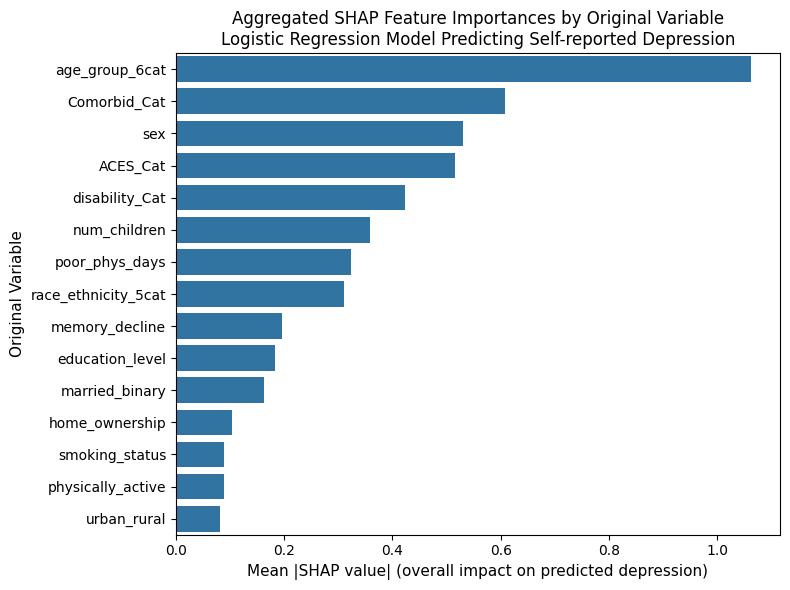


Number of original variables (groups): 24


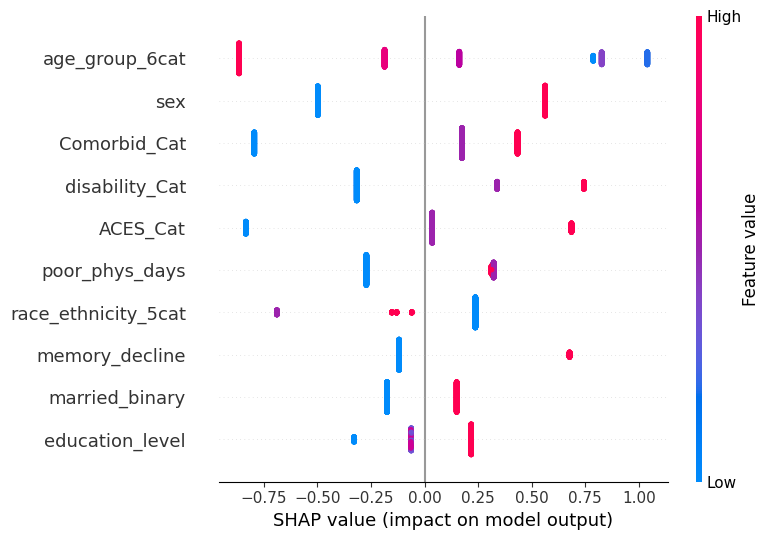

In [ ]:
# ==== Aggregated SHAP Feature Importance + Grouped Beeswarm for Logistic Regression (Depression model) ====
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# -------------------------------------------------------------------
# 0) Pull LR pipeline and build SHAP explainer
# -------------------------------------------------------------------
# Assumes:
#   fitted["LR"] -> trained LR pipeline (prep + smote + clf)
#   X_test       -> original test DataFrame (same columns used in training)
#   y_test       -> binary outcome (0/1)

lr_model = fitted["LR"]
prep = lr_model.named_steps["prep"]   # ColumnTransformer
clf  = lr_model.named_steps["clf"]    # LogisticRegression

# Transform X_test (no SMOTE at inference)
X_test_tx = prep.transform(X_test)

# Get original feature names used by the transformer
feature_cols = prep.feature_names_in_.tolist() if hasattr(prep, "feature_names_in_") else X_test.columns.tolist()

# Get post-encoding feature names
oh = prep.named_transformers_["cat"].named_steps["onehot"]
feat_names = list(oh.get_feature_names_out(input_features=feature_cols))

# Use LinearExplainer for logistic regression
# (feature_perturbation="interventional" is robust; falls back gracefully if unavailable)
try:
    explainer = shap.LinearExplainer(clf, X_test_tx, feature_perturbation="interventional")
except TypeError:
    explainer = shap.LinearExplainer(clf, X_test_tx)

shap_vals = explainer.shap_values(X_test_tx)

# Handle output shapes across SHAP versions:
# - (n_samples, n_features)
# - list [class0, class1]
# - (n_samples, n_features, n_classes)
if isinstance(shap_vals, list):
    shap_vals_pos = shap_vals[1]
elif getattr(shap_vals, "ndim", 0) == 3:
    shap_vals_pos = shap_vals[:, :, 1]
else:
    shap_vals_pos = shap_vals

# -------------------------------------------------------------------
# 1) Aggregate SHAP values by original variable (post-OHE groups)
# -------------------------------------------------------------------
def base_var(name: str) -> str:
    """
    Convert one-hot feature names like:
      'race_ethnicity_5cat_3' or 'sex_1'
    back to the original variable name.
    Keeps underscores in the original variable name.
    """
    if "_" in name:
        return name.rsplit("_", 1)[0]
    return name

mean_abs = np.mean(np.abs(shap_vals_pos), axis=0)

agg = (
    pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
      .assign(base=lambda d: d["feature"].map(base_var))
      .groupby("base", as_index=False)["mean_abs_shap"].sum()
      .sort_values("mean_abs_shap", ascending=False)
)

print("Top variables by aggregated mean |SHAP| values (LR Depression model):")
display(agg.head(15))

# -------------------------------------------------------------------
# 2) Bar plot of aggregated SHAP importances (original variables)
# -------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=agg.head(15),
    x="mean_abs_shap",
    y="base"
)
plt.title(
    "Aggregated SHAP Feature Importances by Original Variable\nLogistic Regression Model Predicting Self-reported Depression"
)
plt.xlabel("Mean |SHAP value| (overall impact on predicted depression)", fontsize=11)
plt.ylabel("Original Variable", fontsize=11)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3) Grouped SHAP beeswarm at original-variable level
# -------------------------------------------------------------------
# Build mapping from encoded features -> base variable
groups = {}
for idx, fname in enumerate(feat_names):
    b = base_var(fname)
    groups.setdefault(b, []).append(idx)

base_vars = list(groups.keys())
print(f"\nNumber of original variables (groups): {len(base_vars)}")

# Build grouped SHAP matrix: sum SHAP over one-hot columns for each original variable
n_samples = shap_vals_pos.shape[0]
shap_grouped = np.zeros((n_samples, len(base_vars)))

for j, b in enumerate(base_vars):
    cols = groups[b]
    shap_grouped[:, j] = shap_vals_pos[:, cols].sum(axis=1)

# Build a matching X matrix (original variables) for coloring in beeswarm
X_grouped = X_test[base_vars].copy()
for col in X_grouped.columns:
    X_grouped[col] = X_grouped[col].astype("category").cat.codes

# Beeswarm plot at original-variable level
shap.summary_plot(
    shap_grouped,
    X_grouped.values,
    feature_names=base_vars,
    max_display=10,
    show=True
)
